In [47]:
# Jade Chongsathapornpong, July 2023
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, KMeans

# optional larch imports to use standard XAFS normalization instead of my approach
from larch.io import read_ascii
from larch.xafs import sort_xafs, pre_edge, autobk

# for convolution of FDMNES reference outputs
from larch.math import convolution1D

#%matplotlib nbagg

# Comparing averaged spectra: Normalization, PCA, Clustering
This plots averaged spectra from PyMCA. The goal is to compare the spectra, and identify which ones look "the same" via clustering.

In [48]:
### Zn K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# # This is everything to plot
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

# # This is what we want to fit the PCA to
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit',
#          'W37_ZnCo_RTInit',
#          'W39_HEO_RTInit',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

### Cu K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Cu_Kedge'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'CuO_Aldritch_RT']
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit',
#          'CuO_Aldritch_RT']

### Co K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Co_Kedge_Old'
names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
         'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
         'W35_Co_RTInit', 'W35_Co_RTFinal', 'W35_Co_900C',
         'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
         'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
         'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT'] #
names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
         'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
         'W35_Co_RTInit',
         'W37_ZnCo_RTInit',
         'W39_HEO_RTInit',
         'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT']

This next cell defines normalization functions used for my quick test of PCA, and does NOT depend on `larch`. 

In [49]:
def interpolate_xas(in_energies, in_signal):
    """Args:
        - in_energies (list of array)
        - in_signal (list of array)
    Returns:
        - out_energies (array) a single array of energies interpolated to
        - out_signals (list of array) all the interpolated signals
    Uses the SHORTEST array in in_energies, and interpolates the remaining in_signal arrays to match it.
    """
    shortest_idx = np.argmin([len(E) for E in in_energies])
    print(f"Mapping to {len(in_energies[shortest_idx])} points from spectra up to {np.max([len(E) for E in in_energies])} long")
    out_energies = in_energies[shortest_idx]
    out_signals = [np.interp(out_energies, energy, signal) for energy, signal in zip(in_energies, in_signal)]
    return out_energies, out_signals

def start_end_norm(signal, head=20, tail=20):
    """Args:
        - signal (array-like): the signal to be normalized
        - head (int): how many of the first samples of the signal to consider
        - tail (int): how many of the last samples of the signal to consider
    Returns:
        - signal scaled such that the average of the tail samples is 1
            and that of the head is 0."""
    start_avg = np.nanmean(signal[:head])
    ret0 = signal - start_avg
    end_avg = np.nanmean(ret0[-tail:])
    return ret0 / end_avg

def subtract_average(signals):
    """Args:
        - signal (2D array-like): of shape (# signals, # data points per signal)
    Returns:
        - signals with their averages subtracted"""
    average = np.mean(signals, axis=0)
    return signals - average

def deltamu_from_names(names, start=100, end=2000):
    """Args:
        - names (formatted as in the first cell)
    Returns:
        - array of energies corresponding to the differences
        - differences in normalized mu from the average
    Uses interpolate_xas to map all signals to one signal's energy values."""
    energies = []
    normed_mus = []
    for name in names:
        arr = np.genfromtxt(join(root, name + '.csv'), delimiter=',').transpose()
        energies.append(arr[0][start:end])
        norm = start_end_norm(arr[1][start:end]) # take only a limited range
        normed_mus.append(norm)
    energy, normed_interp_mus = interpolate_xas(energies, normed_mus)
    delta_mus = subtract_average(np.array(normed_interp_mus))
    return energy, delta_mus

def spectra_from_names(names, start=100, end=2000):
    energies = []
    spectra = []
    for name in names:
        arr = np.genfromtxt(join(root, name + '.csv'), delimiter=',').transpose()
        energies.append(arr[0][start:end])
        spectra.append(start_end_norm(arr[1])[start:end])
    return interpolate_xas(energies, spectra)

This next cell defines my `larch` macros for normalization and background subtraction, for my final PCA workflow.

In [50]:
def larch_load_chik(path, name, labels='energy_cenc, mu_fluo'):
    """Args:
        - path to csv file with labels, e.g. energy_cenc and mu_fluo (can be changed)
        - name to associate with the group
        - labels of columns to read
        - keV: whether the energies given are in keV (True) or eV (False)
        - conv: whether or not to perform a convolution of the input data
    Returns:
        - a Larch Group object with attributes initialized as done in xas_viewer
            according to the Larch buffer"""
    g = read_ascii(path, labels=labels)
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = 1000.*g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    g.norm_poly = 1.0 * g.norm
    autobk(g) # use defaults for auto-background-subtraction
    return g

def kchik_from_names(names, kweight=2):
    """Args:
        - names (formatted as in the first cell)
    Returns:
        - ordered list of arrays of wavenumbers corresponding to
        - ordered list of arrays of relative absorption (chi) weighted by k^kweight
    Uses interpolate_xas to map all signals down to one signal's wavenumbers
    """
    wavenumbers = []
    chiks = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load_chik(path, name)
        wavenumbers.append(lgrp.k)
        chiks.append(lgrp.chi * np.power(lgrp.k, kweight))
    return interpolate_xas(wavenumbers, chiks)

## Normalizing and plotting all references - no `larch`
First, I am normalizing the signals so that the averages of their first and last N points are 0 and 1, respectively. Then, I'm taking all the normalized signals, averaging them, then subtracting off that average from all of them. I call this signal $\Delta\mu$.

Mapping to 499 points from spectra up to 1900 long


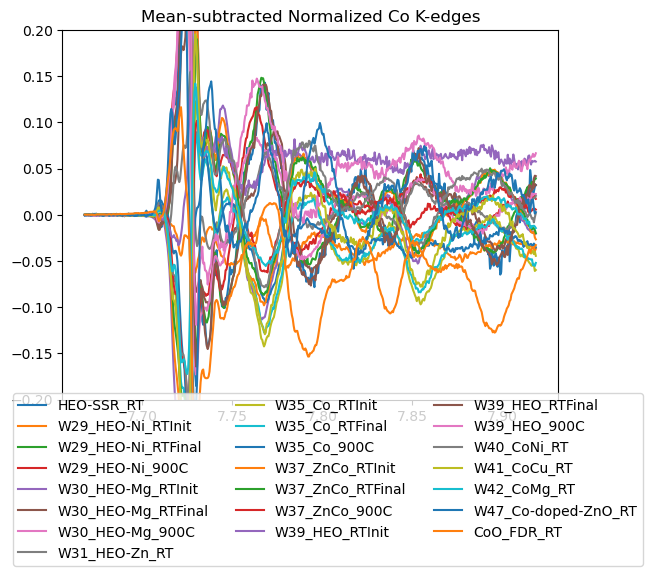

In [51]:
energies, delta_mus = deltamu_from_names(names_all)

for i, dmu in enumerate(delta_mus):
    plt.plot(energies, dmu, label=names_all[i])

plt.title("Mean-subtracted Normalized Co K-edges")
#plt.xlim(9.6, 9.9)
plt.ylim(-0.2, 0.2)
plt.legend(ncol=3, loc=(-0.1, -0.45))
#plt.savefig(r"Output/BM23/Zn_meansub2", dpi=300)
plt.show()

## Normalizing and plotting references - using `larch`

In [41]:
K, CHIK = kchik_from_names(names_all, kweight=2)

Mapping to 144 points from spectra up to 324 long


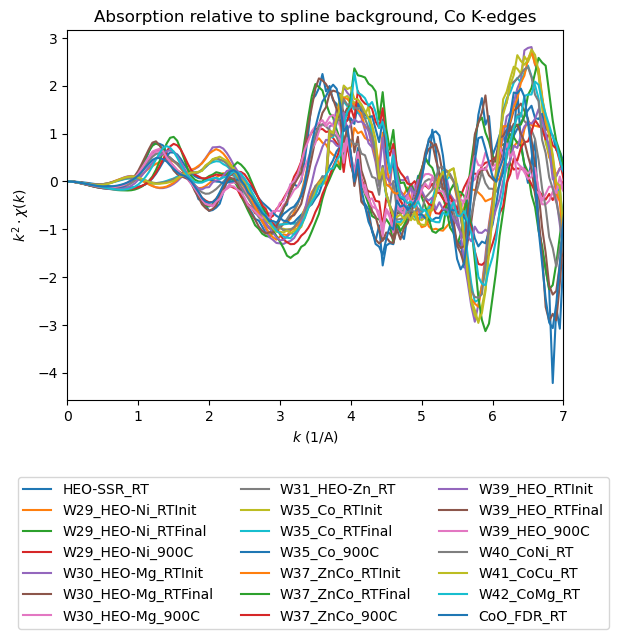

In [42]:
for i, chik in enumerate(CHIK):
    plt.plot(K, chik, label=names_all[i])
plt.title("Absorption relative to spline background, Co K-edges")

plt.xlim(0, 7)
plt.xlabel('$k$ (1/A)')
plt.ylabel('$k^2 \cdot \chi(k)$')
plt.legend(ncol=3, loc=(-0.1, -0.62))
# plt.savefig('Output/BM23/ChiK_Co')
plt.show()

## PCA and Unsupervised Clustering
To identify similar-looking signals, I will try using some sort of clustering method, based on the PCA-decomposition of their deviations from the average. This will work using either the $\Delta\mu$ or the `larch`-based $\chi(k)$.

Mapping to 144 points from spectra up to 324 long
[0.60336881 0.29159493 0.05394376 0.02111027 0.013161   0.00518148]


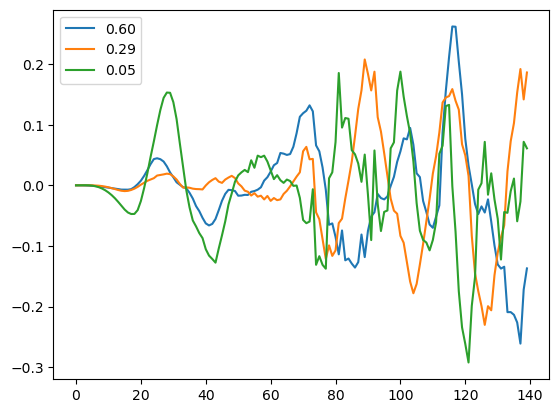

In [43]:
# PCA expects (n_samples (each signal is a "sample"), n_features (data pts/signal))
st = 0
en = 140
# _, dmus = deltamu_from_names(names_for_pca) # no larch
_, weighted_chiks = kchik_from_names(names_for_pca) # larch

cropped_chiks = [chik[st:en] for chik in weighted_chiks]

A = np.array(cropped_chiks)

pca = PCA(n_components=6)
pca.fit(A)
print(pca.explained_variance_ratio_)
for i in range(3):
    plt.plot(pca.components_[i][0:1000], label=f"{pca.explained_variance_ratio_[i]:.2f}")
# plt.xlim(150,600)
# plt.ylim(-0.15,0.15)
plt.legend()
# plt.savefig("Output/BM23/PC_Co", dpi=300)
plt.show()

# Save the principal components
# np.savetxt('Output/BM23/principalcomponents_Chik_Co.csv', pca.components_, delimiter=',')

In [44]:
# reduced = pca.transform(np.array(delta_mus)) # apply PCA to all signals
reduced = pca.transform(np.array([c[st:en] for c in CHIK]))
print(f"{reduced.shape[0]} signals embedded in {reduced.shape[1]} dimensions.") 

# Save the PCA embeddings of each signal
# embedding_df = pd.DataFrame(reduced)
# embedding_df['sample'] = names_all
# embedding_df.to_csv('Output/BM23/pca_embeddings_chik_Co.csv')

# Perform clustering technique
ap = AffinityPropagation().fit(reduced)
# nc = 6
# km = KMeans(n_clusters=nc, n_init='auto').fit(reduced)

clusterings = {key: [] for key in np.unique(ap.labels_)}
for i, name in enumerate(names_all):
    clusterings[ap.labels_[i]].append((i, name))
    
print(clusterings)

21 signals embedded in 6 dimensions.
{0: [(3, 'W29_HEO-Ni_900C'), (5, 'W30_HEO-Mg_RTFinal'), (6, 'W30_HEO-Mg_900C'), (7, 'W31_HEO-Zn_RT'), (16, 'W39_HEO_900C')], 1: [(4, 'W30_HEO-Mg_RTInit'), (8, 'W35_Co_RTInit'), (9, 'W35_Co_RTFinal'), (11, 'W37_ZnCo_RTInit'), (17, 'W40_CoNi_RT'), (18, 'W41_CoCu_RT')], 2: [(1, 'W29_HEO-Ni_RTInit'), (10, 'W35_Co_900C'), (12, 'W37_ZnCo_RTFinal'), (13, 'W37_ZnCo_900C'), (14, 'W39_HEO_RTInit'), (19, 'W42_CoMg_RT')], 3: [(0, 'HEO-SSR_RT'), (2, 'W29_HEO-Ni_RTFinal'), (15, 'W39_HEO_RTFinal'), (20, 'CoO_FDR_RT')]}


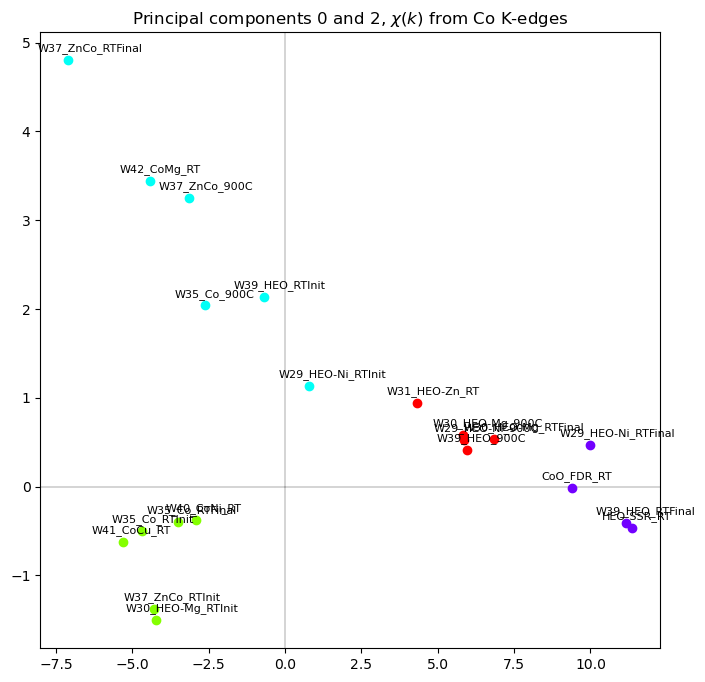

In [46]:
dim0 = 0 # 0, 1, 2, 3, 4, 5; dimensions of the PCA
dim1 = 2

adj_text_idx = ()#(13, 15) # indices into names_all for which to adjust text position

fig, ax = plt.subplots(figsize=(8,8))
for i, signalvec in enumerate(reduced):
    adj = 0.2 if i in adj_text_idx else 0.
    ax.axhline(0, linewidth=0.01, color='k')
    ax.axvline(0, linewidth=0.01, color='k')
    ax.plot(signalvec[dim0], signalvec[dim1], 'o', c=cm.hsv(ap.labels_[i]/(max(ap.labels_) + 1)))
    ax.text(signalvec[dim0]-1-adj, signalvec[dim1]+0.1+adj, names_all[i], fontsize=8)
ax.set_title(f"Principal components {dim0} and {dim1}, $\chi(k)$ from Co K-edges")
# plt.savefig(f"Output/BM23/Co_PCA/PCA_Co_Chik_{dim0}_{dim1}", dpi=300)
plt.show()

## Replotting the spectra that were clustered according to the PCA and comparing FDMNES simulations
I looked along dimensions 0, 1, and 2, and corroborated groupings between them. This could be automated using something like K-means or medoids.
I plotted things that are in the same clusters, and in far-separated clusters. I found the PCA overfits to temperature dependence, but is still useful.

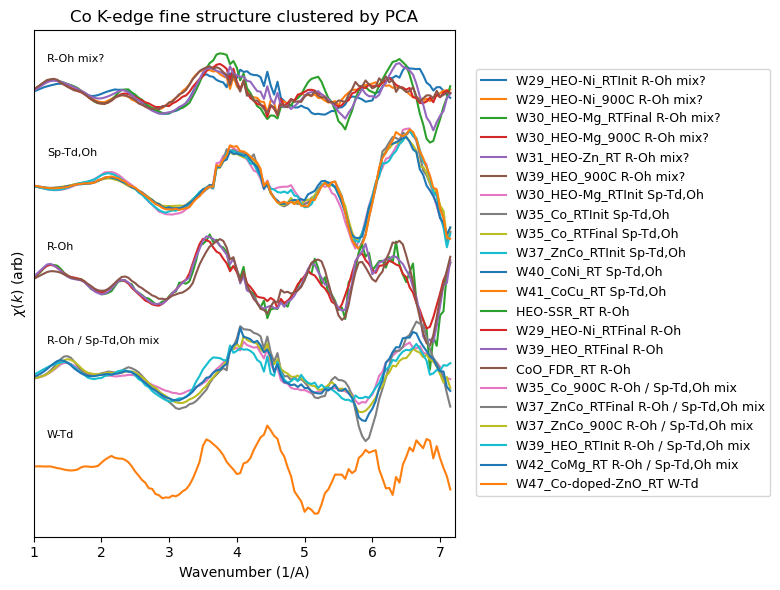

In [29]:
ref_root = r'FDMNES'
names_ref = ['CoO_Oh', 'Co15Zn85O_Co','Co3O4_Oh', 'Co3O4_Td']

kwt = 2
ref_scale = 0.7

clusternames = {0: 'R-Oh mix?', 1: 'Sp-Td,Oh', 2: 'R-Oh', 3: 'R-Oh / Sp-Td,Oh mix', 4: 'W-Td'}

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(1,7.22)
spec_offset = 0

# Plot experimental data
for key, members in clusterings.items():
    clustername = clusternames[key]
    ax.text(1.2, spec_offset+1.5, clustername, fontsize=8)
    for pair in members:
        index = pair[0]
        samplename = pair[1]
        chis = CHIK[index] + spec_offset
        ax.plot(K, chis, label=f'{samplename} {clustername}')
    spec_offset -= 4.5

ax.set_yticks([])
ax.set_xlabel('Wavenumber (1/A)')
ax.set_ylabel('$\chi(k)$ (arb)')
ax.set_title('Co K-edge fine structure clustered by PCA')
ax.legend(ncol=1, loc=(1.05, 0.08), fontsize=9)
plt.tight_layout()
# plt.savefig('Output/BM23/Co_ClusteredSpecs', dpi=300)
plt.show()

Below I'll plot the spectra without background subtracted ($\mu$ instead of $\chi$).

Mapping to 469 points from spectra up to 1870 long


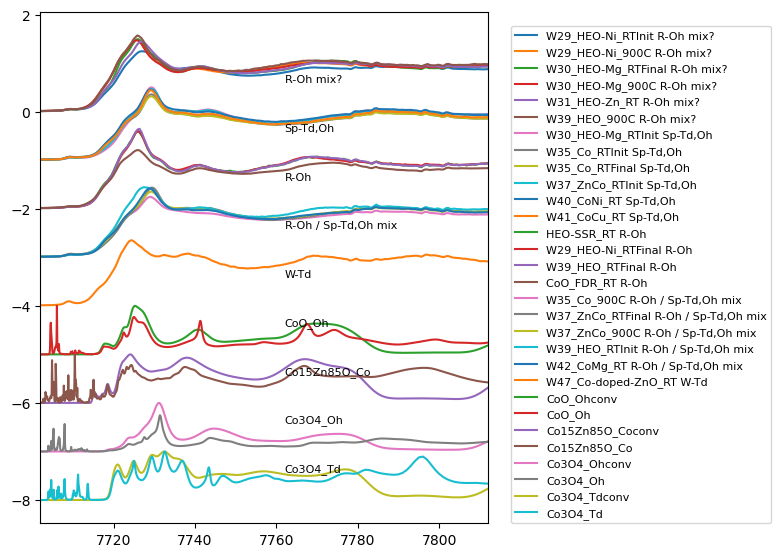

In [33]:
# %matplotlib nbagg
energy, mus = spectra_from_names(names_all, start=130, end=2000)

fig, ax = plt.subplots(figsize=(8,6))
spec_offset = 0
edge_energy = 7712

# plot experiment
for key, members in clusterings.items():
    clustername = clusternames[key]
    ax.text(edge_energy + 50, spec_offset+0.6, clustername, fontsize=8)
    for pair in members:
        index = pair[0]
        samplename = pair[1]
        ax.plot(energy * 1000, mus[index] + spec_offset, label=f'{samplename} {clustername}')
    spec_offset -= 1
    
# miscellaneous plots
# path = join(ref_root, 'Co3O4_Oh', 'Co3O4_Oh.txt')
# lgOh = larch_load_chik(path, 'Co3O4_Oh', labels='Energy, xanes', keV=False, conv=True)
# path = join(ref_root, 'Co3O4_Td', 'Co3O4_Td.txt')
# lgTd = larch_load_chik(path, 'Co3O4_Td', labels='Energy, xanes', keV=False, conv=True)
# spinel_mu = (lgTd.mu / 3) + (2 * lgOh.mu / 3) # AB2O4; A is tetrahedral, B is octahedral
# arbitrary_mu = spinel_mu / np.max(spinel_mu)
# ax.plot(lgOh.energy + edge_energy, arbitrary_mu + spec_offset, label='Spinel')
# ax.text(edge_energy + 50, spec_offset+0.6, 'Spinel', fontsize=8)
# spec_offset -= 1

# plot references
for name in names_ref:
    path = join(ref_root, name, name + '.txt')
    ax.text(edge_energy + 50, spec_offset+0.6, name, fontsize=8)
    lgrp = larch_load_chik(path, name, labels='Energy, xanes', keV=False, conv=True)
    arbitrary_mu = lgrp.mu / np.max(lgrp.mu)
    ax.plot(lgrp.energy + edge_energy, arbitrary_mu + spec_offset, label=name+'conv')
    data = np.genfromtxt(path, skip_header=5).transpose()
    E = data[0]
    mu = data[1] / np.max(data[1])
    ax.plot(data[0] + edge_energy, mu + spec_offset, label=name)
    spec_offset -= 1

plt.xlim(edge_energy - 10, edge_energy + 100)
plt.legend(ncol=1, loc=(1.05, 0.0), fontsize=8)
plt.tight_layout()
# plt.savefig('Output/BM23/Co_withRef', dpi=300)
plt.show()